Importing Neccesary Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Subset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import zipfile
import os, os.path

Loading Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/Raw_Data_Split-20240703T015611Z-001.zip', 'r')
zip_ref.extractall('/content/Raw_Data_v2')
zip_ref.close()

Exploratory Data Analysis

In [5]:
zip_path = '/content/drive/MyDrive/Colab Notebooks/Raw_Data.zip'
extract_path = '/content/drive/MyDrive/Colab Notebooks/Raw_Data/'

#Unzipping folder
#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    #zip_ref.extractall(extract_path)

#Defining path to access each class folder
subdir_path = os.path.join(extract_path, "Raw_Data")
subdir_list = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

#Function to count the number of images
def count_images(directory):
    return len([name for name in os.listdir(directory)
                if os.path.isfile(os.path.join(directory, name)) and
                name.lower().endswith(('.png', '.jpg', '.jpeg'))])

#Loop through each class, print number of images and total number of images
tot_images = 0
for subfolder in subdir_list:
    subfolder_path = os.path.join(subdir_path, subfolder)
    if os.path.isdir(subfolder_path):
        num_images = count_images(subfolder_path)
        tot_images += num_images
        print(f"Number of images in '{subfolder}': {num_images}")
print(f"Total number of images: {tot_images}")

Number of images in 'glioma_tumor': 2547
Number of images in 'meningioma_tumor': 2582
Number of images in 'no_tumor': 2396
Number of images in 'pituitary_tumor': 2658
Total number of images: 10183


In [6]:
#!pip install split_folders

In [7]:
#import splitfolders
#splitfolders.ratio('/content/drive/MyDrive/Colab Notebooks/Raw_Data/Raw_Data', '/content/drive/MyDrive/Colab Notebooks/Raw_Data_Split',seed=999, ratio=(.6,.2,.2))

In [8]:
split_list = ['train', 'val', 'test']
subdir_path = '/content/drive/MyDrive/Colab Notebooks/Raw_Data_Split'

tot_images = 0
for split in split_list:
    split_path = os.path.join(subdir_path, split)
    if os.path.isdir(split_path):
        print(f"{split} set image distribution:")
        for class_folder in subdir_list:
            class_folder_path = os.path.join(split_path, class_folder)
            if os.path.isdir(class_folder_path):
                num_images = count_images(class_folder_path)
                tot_images += num_images
                print(f"  Number of images in class '{class_folder}': {num_images}")
print(f"Total number of images: {tot_images}")

train set image distribution:
  Number of images in class 'glioma_tumor': 1528
  Number of images in class 'meningioma_tumor': 1549
  Number of images in class 'no_tumor': 1437
  Number of images in class 'pituitary_tumor': 1594
val set image distribution:
  Number of images in class 'glioma_tumor': 509
  Number of images in class 'meningioma_tumor': 516
  Number of images in class 'no_tumor': 479
  Number of images in class 'pituitary_tumor': 531
test set image distribution:
  Number of images in class 'glioma_tumor': 510
  Number of images in class 'meningioma_tumor': 517
  Number of images in class 'no_tumor': 480
  Number of images in class 'pituitary_tumor': 533
Total number of images: 10183


Image Augmentation and DataLoader creation

In [9]:
# randomly changing color intensity in each image by a constant value

folder_path = '/content/Raw_Data_v2/Raw_Data_Split/train'

for Class in ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']:
  class_path = os.path.join(folder_path, Class)

  # List contents of the folder
  contents = os.listdir(class_path)

  for img_name in contents:
    img_path = os.path.join(class_path, img_name)
    img = plt.imread(img_path)

    random_num = np.random.randint(0,1)
    if(random_num < 0.5):
      img = img/255
      img = np.clip((img + 0.25), 0, 1)

In [10]:
def create_loaders(batch_size):

    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Grayscale(num_output_channels=1),
                                    transforms.Resize((224, 224)),
                                    transforms.Normalize((0.5), (0.5))
                                    ])

    augment = transforms.Compose([transforms.ToTensor(),
                                    transforms.Grayscale(num_output_channels=1),
                                    transforms.Resize((224, 224)),
                                    transforms.Normalize((0.5), (0.5)),
                                    transforms.RandomRotation(45),
                                    transforms.GaussianBlur(5, (0.1,2))
                                    ])



    #Create Datasets for each set and apply transformation to training dataset
    train_dataset = datasets.ImageFolder(root='/content/Raw_Data_v2/Raw_Data_Split/train', transform=augment)
    val_dataset = datasets.ImageFolder(root='/content/Raw_Data_v2/Raw_Data_Split/val', transform = transform)
    test_dataset = datasets.ImageFolder(root='/content/Raw_Data_v2/Raw_Data_Split/test', transform = transform)


    #Create DataLoaders for each set
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

    return train_loader, val_loader, test_loader

Modified ResNet

In [11]:
# Load pre-trained model and modify the final layer
from torchvision import models
model = models.resnet18(pretrained=True)

# Modify the first convolutional layer to accept 1 channel instead of 3
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the final layer to have 4 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)  # 4 classes

def freeze_layers(model):
    layers = list(model.children())
    num_layers_to_freeze = len(layers) // 2

    for i in range(num_layers_to_freeze):
        for param in layers[i].parameters():
            param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 130MB/s]


In [12]:
!nvidia-smi

Wed Jul  3 18:56:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   39C    P8              12W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [13]:
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

CUDA is available!  Training on GPU ...


In [14]:
train_loader, val_loader, test_loader = create_loaders(128)

Accuracy and Train functions

In [15]:
def get_accuracy(model, train_loader, val_loader, train=False):
    if train:
        data = train_loader
    else:
        data = val_loader

    correct = 0
    total = 0
    for imgs, labels in data:

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################

        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

Epoch loss: 0.005197896156460047 Train acc: 0.3652586771447282 Validation acc: 0.36265356265356263
Epoch loss: 0.003715052967891097 Train acc: 0.5771119842829077 Validation acc: 0.5911547911547912
Epoch loss: 0.0034071619156748056 Train acc: 0.6529142108709889 Validation acc: 0.6643734643734643
Epoch loss: 0.0025210499297827482 Train acc: 0.6820563195808775 Validation acc: 0.6722358722358722
Epoch loss: 0.0027833767235279083 Train acc: 0.712671905697446 Validation acc: 0.714987714987715
Epoch loss: 0.0019499033223837614 Train acc: 0.7786509495743288 Validation acc: 0.7498771498771499
Epoch loss: 0.0016819911543279886 Train acc: 0.8131958087753766 Validation acc: 0.7316953316953317
Epoch loss: 0.0017499320674687624 Train acc: 0.8392272429600524 Validation acc: 0.8117936117936118
Epoch loss: 0.0021429662592709064 Train acc: 0.8364440078585462 Validation acc: 0.7941031941031941
Epoch loss: 0.0017301157349720597 Train acc: 0.8439751146037983 Validation acc: 0.8196560196560196
Epoch loss: 0

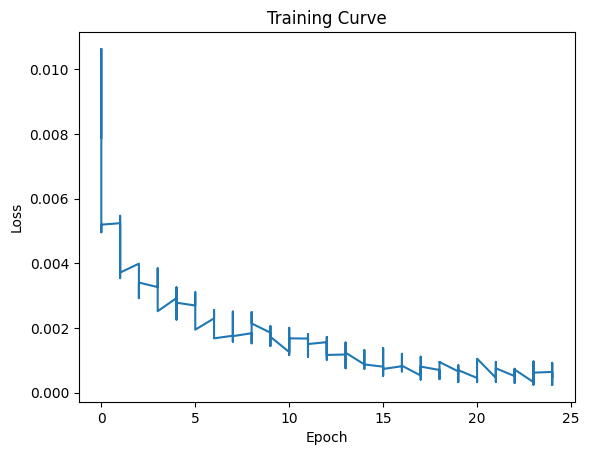

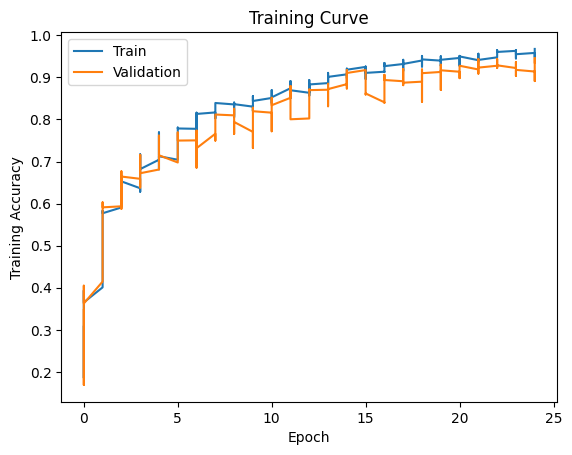

Final Training Accuracy: 0.9677472167648985
Final Validation Accuracy: 0.9356265356265356


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

iters, losses, train_acc, val_acc = [], [], [], []

num_epochs = 25
batch_size = 128

# training
n = 0 # the number of iterations
for epoch in range(num_epochs):
    for imgs, labels in iter(train_loader):

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
        #############################################

        out = model(imgs)             # forward pass

        loss = criterion(out, labels) # compute the total loss
        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader, val_loader, train=True)) # compute training accuracy
        val_acc.append(get_accuracy(model, train_loader, val_loader, train=False))  # compute validation accuracy
    n += 1
    print("Epoch loss: {} Train acc: {} Validation acc: {}".format(losses[-1], train_acc[-1], val_acc[-1]))

# plotting
plt.title("Training Curve")
plt.plot(iters, losses, label="Train")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.title("Training Curve")
plt.plot(iters, train_acc, label="Train")
plt.plot(iters, val_acc, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()

print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))
torch.save(model.state_dict(), 'brain_tumor_model2.pth')

Test function that also computes confusion matrix

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


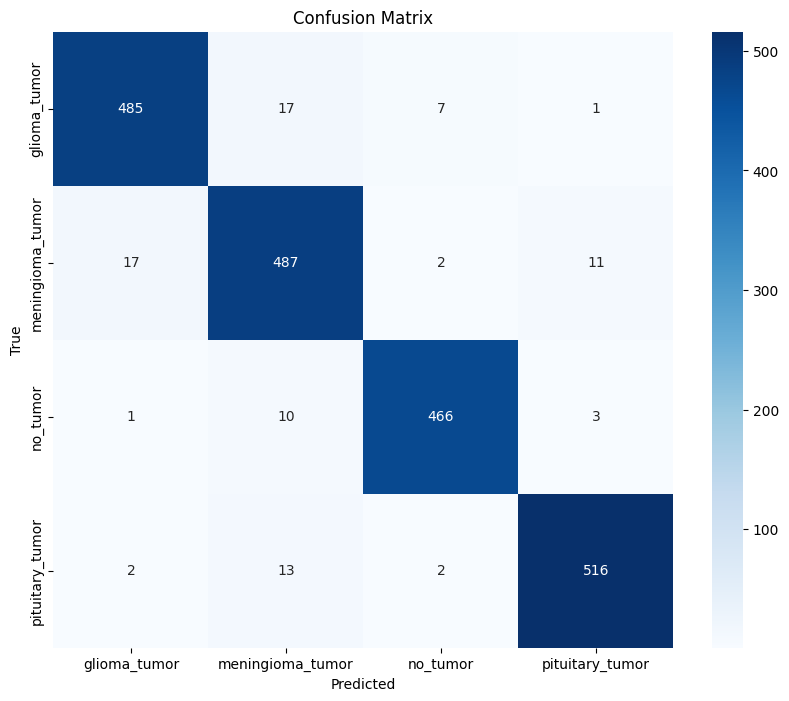

Accuracy: 0.9578


In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def get_accuracy_test(model, test_loader):
    model.eval()  # Set the model to evaluation mode

    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in test_loader:
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
            #############################################

            output = model(imgs)

            # Select index with maximum prediction score
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total += imgs.shape[0]

            # Store predictions and labels for confusion matrix
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_loader.dataset.classes, yticklabels=test_loader.dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy

accuracy = get_accuracy_test(model, test_loader)
print(f'Accuracy: {accuracy:.4f}')
